In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
from tqdm.notebook import tqdm

In [4]:
from run_everything import run_hf, run_pyhf
import pyhf
import scipy.stats

Welcome to JupyROOT 6.20/04


In [5]:
data = {
    "binning": [1, 0.5, 1.5],
    "bindata": {"data": [80.0], "bkg": [50.0], "bkgerr": [7.0], "sig": [25.0]},
}

In [6]:
run_hf(data)

{'p0_obs': 0.0039368831915863375,
 'p0_exp': [1.2204714710428561e-05,
  0.000640523742623191,
  0.013202867164347749,
  0.11119604157562324,
  0.412860797283259]}


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

reading input : config/example.xml
output file prefix is : ./results/example
Found Channels:  ./config/example_channel.xml

Creating new measurement: 
Measurement Name: GaussExample	 OutputFilePrefix: 	 POI: SigXsecOverSM	 Lumi: 1	 LumiRelErr: 0	 BinLow: 0	 BinHigh: 1	 ExportOnly: 1
Constant Params:  Lumi
End Measurement: GaussExample

Done Processing Measurements
Found Measurements:  GaussExample
Parsing Channel: ./config/example_channel.xml
Parsing file: ./config/example_channel.xml : creating a channel named channel1
Setting InputFile for this channel: ./data/data.root
Creating Data Element
Created Data Node with InputFile: ./data/data.root HistoName: data HistoPath: 
Creating Sample Element
Making NormFactor:
	 	 Name: SigXsecOverSM	 V

In [7]:
ndata_range = list(range(50, 200, 5))

In [8]:
hf_pvals = []
for ndata in tqdm(ndata_range):
    hf_pvals.append(run_hf(dict(data, bindata=dict(data["bindata"], data=[ndata]))))



RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

reading input : config/example.xml
output file prefix is : ./results/example
Found Channels:  ./config/example_channel.xml

Creating new measurement: 
Measurement Name: GaussExample	 OutputFilePrefix: 	 POI: SigXsecOverSM	 Lumi: 1	 LumiRelErr: 0	 BinLow: 0	 BinHigh: 1	 ExportOnly: 1
Constant Params:  Lumi
End Measurement: GaussExample

Done Processing Measurements
Found Measurements:  GaussExample
Parsing Channel: ./config/example_channel.xml
Parsing file: ./config/example_channel.xml : creating a channel named channel1
Setting InputFile for this channel: ./data/data.root
Creating Data Element
Created Data Node with InputFile: ./data/data.root HistoName: data HistoPath: 
Creating Sample Element
Making NormFactor:
	 	 Name: SigXsecOverSM	 

In [9]:
pyhf_pvals = []
for ndata in tqdm(ndata_range):
    pyhf_pvals.append(run_pyhf(dict(data, bindata=dict(data["bindata"], data=[ndata]))))

In [10]:
def get_p0_obs_asymptotic_exact(data):
    # http://www.pp.rhul.ac.uk/~cowan/stat/medsig/medsigNote.pdf
    bd = data["bindata"]
    b = bd["bkg"][0]
    tau = b / (bd["bkgerr"][0] ** 2)
    m = tau * b
    n = bd["data"][0]
    return scipy.stats.norm.sf(
        np.sqrt(-2 * (n * np.log((n + m) / ((1 + tau) * n)) + m * np.log((tau * (n + m)) / ((1 + tau) * m))))
    )

In [11]:
get_p0_obs_asymptotic_exact(data)

0.003936878440204013

In [12]:
obs_exact = [
    get_p0_obs_asymptotic_exact(dict(data, bindata=dict(data["bindata"], data=[ndata])))
    for ndata in ndata_range
]

<ipython-input-10-59870acde203>:9: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-2 * (n * np.log((n + m) / ((1 + tau) * n)) + m * np.log((tau * (n + m)) / ((1 + tau) * m))))
/home/nikolai/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/nikolai/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/nikolai/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [13]:
def ratio(x, a1, a2, title="pvalue", label1="ROOT/Histfactory", label2="pyhf"):
    fig, axs = plt.subplots(nrows=2, figsize=(5, 5))
    axs[0].plot(x, a1, label=label1)
    axs[0].plot(x, a2, label=label2)
    axs[1].plot(x, a1 / a2)
    axs[1].set_xlim(*axs[0].get_xlim())
    axs[0].legend()
    axs[0].set_ylabel(title)
    axs[1].set_ylabel("ratio")
    return fig, axs

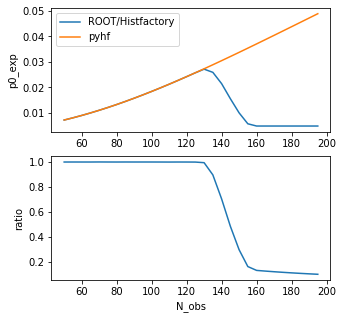

In [14]:
fig, axs = ratio(
    ndata_range,
    np.array([p["p0_exp"][2] for p in hf_pvals]),
    np.array([p["p0_exp"][2] for p in pyhf_pvals]),
    title="p0_exp"
)
axs[1].set_xlabel("N_obs")
plt.show()

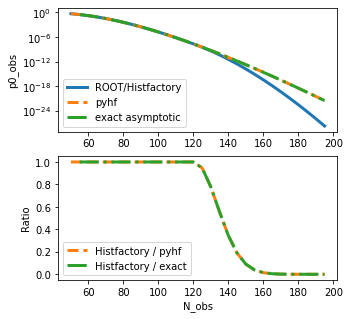

In [15]:
def plot():
    hf = np.array([p["p0_obs"] for p in hf_pvals])
    pyhf = np.array([p["p0_obs"] for p in pyhf_pvals])
    exact = obs_exact
    fig, axs = plt.subplots(nrows=2, figsize=(5, 5))
    lw = 3
    axs[0].plot(ndata_range, hf, linewidth=lw, label="ROOT/Histfactory")
    axs[0].plot(ndata_range, pyhf, "--", linewidth=lw, label="pyhf")
    axs[0].plot(ndata_range, exact, "-.", linewidth=lw, label="exact asymptotic")
    axs[0].set_ylabel("p0_obs")
    axs[0].set_yscale("log")
    axs[0].legend()
    axs[1].plot(ndata_range, hf / pyhf, "--", label="Histfactory / pyhf", color="C1", linewidth=lw)
    axs[1].plot(ndata_range, hf / exact, "-.", label="Histfactory / exact", color="C2", linewidth=lw)
    axs[1].set_ylabel("Ratio")
    axs[1].set_xlabel("N_obs")
    axs[1].legend()
plot()